In [1]:
#import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,Dense, Dropout, BatchNormalization,Input)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Paths
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/archive')


In [4]:
train_dir = '/content/archive/train'
test_dir = '/content/archive/test'

In [5]:
# Image settings
img_height, img_width = 48, 48
batch_size = 16

In [6]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# Class mapping
class_names = list(train_generator.class_indices.keys())
print("Emotion Classes:", class_names)

Emotion Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Class Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


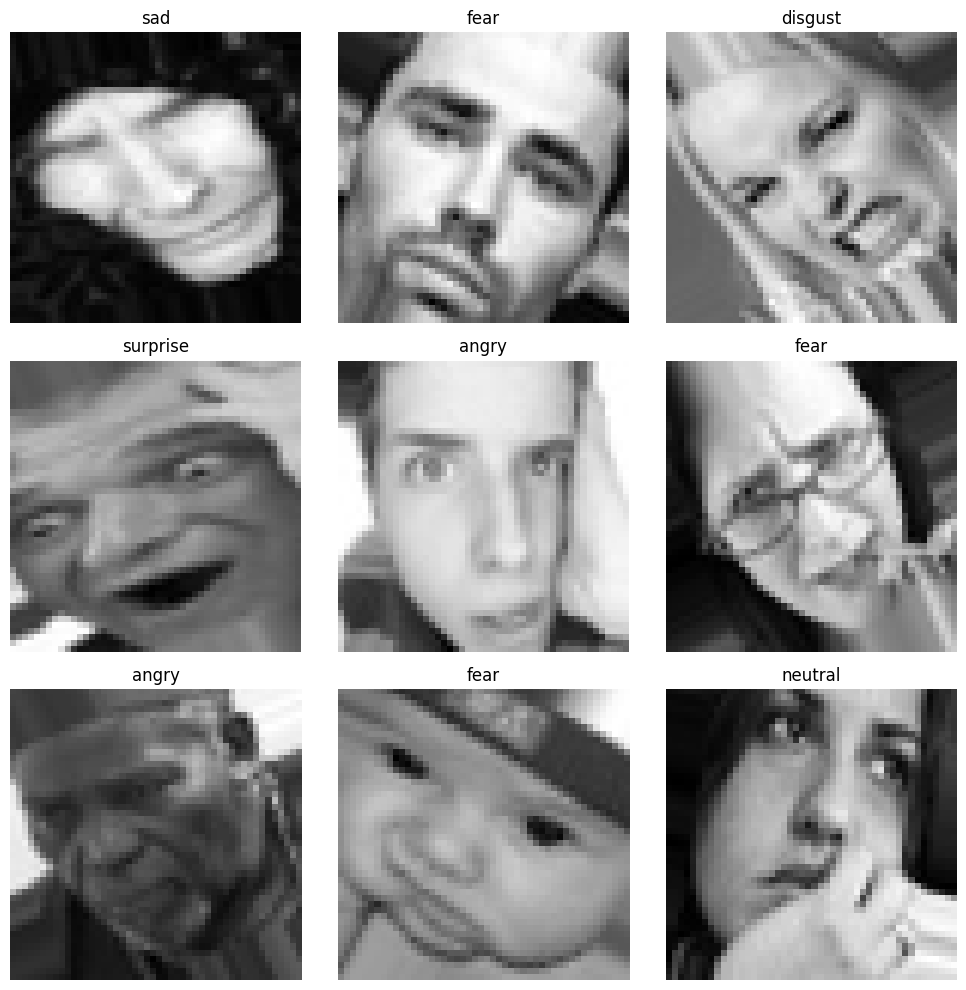

In [8]:
# Get class names from generator
class_names = list(train_generator.class_indices.keys())
print("Class Mapping:", train_generator.class_indices)

# Get a batch of images and labels
images, labels = next(train_generator)

# Show 9 sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    label_index = np.argmax(labels[i])
    plt.title(class_names[label_index])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
# CNN Model Architecture
model = Sequential([
    Input(shape=(img_height, img_width, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,743 (1.36 MB)

 Trainable params: 356,295 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
# Compile the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [11]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/50
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 100s 67ms/step - accuracy: 0.2568 - loss: 1.9932 - val_accuracy: 0.3135 - val_loss: 1.8265 - learning_rate: 0.0010
Epoch 2/50
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 97s 68ms/step - accuracy: 0.3509 - loss: 1.6383 - val_accuracy: 0.3909 - val_loss: 1.5521 - learning_rate: 0.0010
Epoch 3/50
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 91s 63ms/step - accuracy: 0.3957 - loss: 1.5460 - val_accuracy: 0.3963 - val_loss: 1.5681 - learning_rate: 0.0010
Epoch 4/50
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 94s 65ms/step - accuracy: 0.4151 - loss: 1.5022 - val_accuracy: 0.3813 - val_loss: 1.6363 - learning_rate: 0.0010
Epoch 5/50
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 92s 64ms/step - accuracy: 0.4399 - loss: 1.4556 - val_accuracy: 0.4684 - val_loss: 1.3958 - learning_rate: 0.0010
Epoch 6/50
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 96s 67ms/step - accuracy: 0.4534 - loss: 1.4099 - val_accuracy: 0.4633 - val_loss: 1.3945 - learning_rate: 0.0010
Epoch 7/50
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 89s 62ms/step - accur

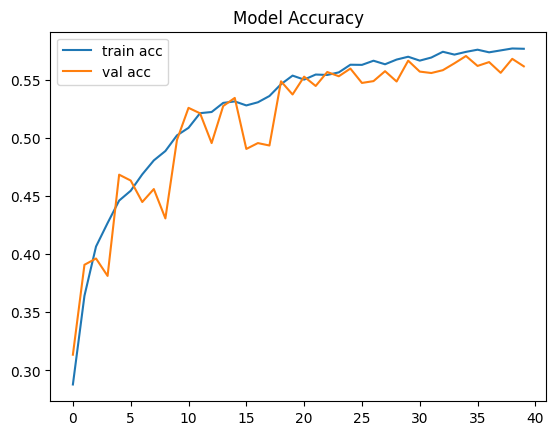

In [12]:
# Plot Training History
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()

In [13]:
# Model Evaluation (on test data)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')

Found 7178 images belonging to 7 classes.
449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5730 - loss: 1.0981
Test accuracy: 58.64%


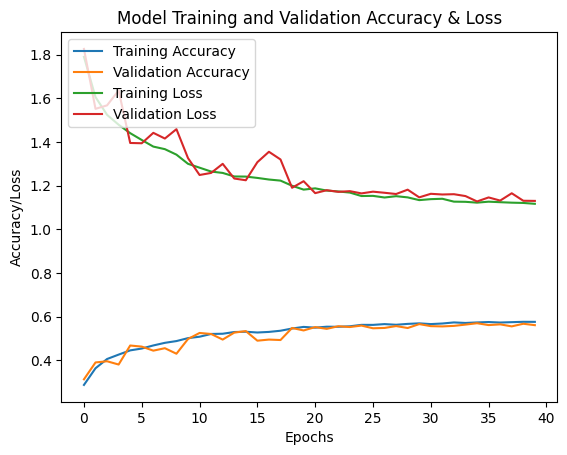

In [14]:
# Plotting training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Model Training and Validation Accuracy & Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.show()


In [15]:
# Save the model
model.save("emotion_recognition_model.h5")

In [16]:
''' Pridicd new Image'''

' Pridicd new Image'

In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')

model = load_model("emotion_recognition_model.h5")
# Recompile the model (with the same settings as during training)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Now, you can evaluate or predict without seeing the warning
model.evaluate(test_generator)
def predict_emotion(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    print("Predicted Emotion:", predicted_class)

    plt.imshow(img_array[0].squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5881 - loss: 1.0836


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Emotion: happy


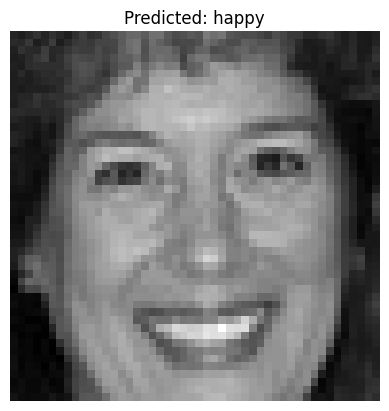

In [22]:
# Example usage:
predict_emotion(img_path = '/content/archive/test/happy/PrivateTest_1735299.jpg')